# Stress Testing with GANs v2.4: Generating FHL based data

*The current notebook implements our revised GAN model (WGAN-GP-Mixed) to generate data based on the FHL public dataset. The improved Generative Adversarial Network is able to work with highly structured multivariate distributions containing both continuous and discrete marginal distributions. The new model is able to overcome any gradient vanishing problems we encountered before and is based on the set of papers described below. The Federal Home Loan Bank Purchased Mortgage dataset is obtained through the [Federal Housing Finance Agency
](https://www.fhfa.gov/DataTools/Downloads/Pages/Public-Use-Databases.aspx) and contains granular loan-level information of US-based mortgages. The dataset contains 82 variables, both continuous and discrete, and has some variables that exhibit a mixed distribution with a Dirac zero delta point. The dataset contains about 65.000 instances making it easily to digest in test settings. The high degree of variability in the data makes it especially challenging to learn the underlying manifold for our GAN model.* 

----
Setup:
  
- [Step 1:](#Environment-variables) Setup working environment
  
- [Step 2:](#The-Federal-Housing-Finance-Agency-dataset) The FHL dataset
  
- [Step 3:](#Preprocessing-of-data) Preproccesing of data
  
- [Step 3:](#Setting-up-our-GAN-model) Implement a composite GAN NN
  
- [Step 4:](#Training-of-the-compiled-GAN-model) Training of the compiled GAN model
  
- [Step 5:](#Evaluating-the-performance-of-our-trained-model) Evaluating the performance of our trained model

- [Step 6:](#Evaluate-the-similarity-between-real-and-artificial-distributions) Evaluate the *similarity* between real and artificial distributions
  
- [Step 7:](#Save-the-calibrated-Generator-and-the-synthetic-dataset) Save the calibrated Generator and the synthetic dataset

---

Main papers utilized:
  
- Overview of GANs: [GAN Google](https://developers.google.com/machine-learning/gan/summary)
  
- Seminal GAN paper of Goodfellow et al.: [GAN Seminal paper](https://arxiv.org/abs/1406.2661)
  
- Instability problems with GANs: [Stabilizing GANs](https://arxiv.org/pdf/1910.00927.pdf)
  
- Wasserstein GAN to deal with vanishing gradients: [WGAN](https://arxiv.org/abs/1701.07875) 
  
- Improved WGAN with Gradient Penalty: [WGAN-GP](https://arxiv.org/abs/1704.00028)
  
- How to add custom gradient penalty in Keras: [WGAN and Keras](https://keras.io/examples/generative/wgan_gp/) and [Change model.fit()](https://keras.io/guides/customizing_what_happens_in_fit/)
  
- Multi-categorical variables and GAN: [Multi-categorical GAN](https://arxiv.org/pdf/1807.01202.pdf)
  
- Alternative to WGAN: [DRAGAN](https://arxiv.org/abs/1705.07215)
  
- Conditional DRAGAN on American Express dataset: [DRAGAN & American Express](https://arxiv.org/pdf/2002.02271.pdf)
  
- Mulitvariate KL-divergence by KNN: [KL by KNN](https://ieeexplore.ieee.org/document/4035959)
  
- Multivariate KL-divergence by  KNN p2: [KL by KNN](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.422.5121&rep=rep1&type=pdf)
  


## Environment variables


Connect to Google Colab Directory containing our repository
(only executed on GColab)

In [1]:
# Initiate notebook (only to be ran once, or when kernel restarts)
activated_reload= False
activated_chdir= False
GCOLAB= False

In [2]:
if GCOLAB:
    from google.colab import drive
    import sys
    drive.mount('/content/gdrive/')
    sys.path.append('/content/gdrive/My Drive/Stress Testing with GANs/notebooks')

## Settings & environment setup 

In [3]:
# Settings for auto-completion: In case greedy is turned off and jedi blocks auto-completion
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

# Autoreload modules: in case in-house libraries aren't finalised
if not activated_reload:
    activated_reload= True
    %load_ext autoreload
    %autoreload 2
    

# Set working directory for user to main project directory 
import os 
if not activated_chdir:
    activated_chdir= True
    os.chdir('..')
    print('Working directory: ', os.getcwd())

Working directory:  C:\Users\ilias\Desktop\Stress Testing with GANs-Gdrive\Stress Testing with GANs


## Import libraries (including in-house build modules)

In [25]:
# Standard libs 
from datetime import datetime
from IPython.display import Latex, Markdown
import os 
import functools
import operator

# External libs 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

# In-house libs 
from src.GAN_functions import * # TODO: modularize source code

In [5]:
## Global settings
# -----------------

# Matplotlib
import matplotlib.font_manager
from matplotlib_inline.backend_inline import set_matplotlib_formats
%config InlineBackend.figure_format = 'png'
%matplotlib inline
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = "serif"
#plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{subdepth}, \usepackage{type1cm}"

# plotly
pio.renderers.default = "notebook+pdf"  

# numpy
np.set_printoptions(precision=2)

# Pandas thousand separator + 2 decimal rounding
pd.set_option('display.float_format', '{:,.2f}'.format)


# pandas latex
pd.set_option('display.notebook_repr_html', True)
def _repr_latex_(self):
    return "\\begin{center} \n %s \n \\end{center}" % self.to_latex()
pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame to latex

# Surpress warnings 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #no info and warnings printed
import warnings
warnings.filterwarnings('ignore')

# The Federal Housing Finance Agency dataset

## Importing the FHL dataset 

We have three general ways of importing the data: 

1. Use a local environment and extract the data from the same environment
2. Use a cloud environment and extract data from the local environment 
3. Use a cloud environment and extract data from the same cloud environment

### Jupyter notebook on local environment 

In [6]:
if not GCOLAB:
    filename= 'FHLbank.csv'
    path= os.path.join('data/raw', filename)
    FHL_bank = pd.read_csv(path)

### Google Colab when importing dataset from local environment  

In [7]:
if GCOLAB:
    # Import files module 
    from google.colab import files
    # Upload FHL_bank dataset into GColab 
    FHL_bank = files.upload()
    # Read the file
    import io
    FHL_bank = pd.read_csv(io.BytesIO(ppnr['FHLbank.csv']))
    # Convert to the right data type 
    FHL_bank = FHL_bank.astype(dtype = 'float64') 

### Google Colab when importing dataset directly from Google Drive


In [8]:
if GCOLAB:
    # Read csv file into Colaboratory
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    # Authenticate and create the PyDrive client
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

In [9]:
if GCOLAB:
    # Shareable link from the dataset in Google drive 
    link= 'https://drive.google.com/file/d/1lqeFxTx3MEZKhwowRWzUKTdYPpwvWDUd/view?usp=sharing'
    #we only need the id-key portion of the link
    id= '1lqeFxTx3MEZKhwowRWzUKTdYPpwvWDUd'

    # Import dataset
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('FHLbank.csv')  
    FHL_bank = pd.read_csv('FHLbank.csv')

## Brief overview of the dataset

The FHL dataset contains 65,703 mortgages granted within the US in 2018, with no missing
values. The median borrower(s) total annual income is equal to
$\$95,000$ USD, whereas the median family income of the
immediate area where the house is purchased is only
$\$73,600$ USD. The median interest rate is set to $4.63\%$
whereas the average rate is slightly lower ($4.55\%$) indicating that the
interest rate is slightly left-skewed. When looking at the amount
borrowed, we see that the median amount is equal to
$\$211,000$ USD while the average amount is
$\$237,000$ USD, indicating a right-skewed distribution. Moving on to the loan-to-value, we see that the interquartile ranges from 72% to 85%, with a mean value of 77%. The LTV value exceeds the 100% mark for a substantial amount of mortgages (about $2\%$ of all mortgages).

In [7]:
# Missing values 
print('Missing values:', FHL_bank.isnull().values.any())
# Quick overview of random set of variables within the dataset
display(FHL_bank.sample(n=12,axis='columns').head())

Missing values: False


Race5  FedGuar     PrepayP  HOEPA  Bed2       Rent1  Corace4  BoEth  \
0      6        2  12/31/9999      2    98  9999999999        6      3   
1      6        2  12/31/9999      2    98  9999999999        6      2   
2      6        2  12/31/9999      2    98  9999999999        6      2   
3      6        2  12/31/9999      2    98  9999999999        8      2   
4      6        1  12/31/9999      2    98  9999999999        8      2   

    FeatureID  AssignedID  Product  Self  
0  9999999999     2131406        1     2  
1  9999999999     2131407        1     2  
2  9999999999     2131408        1     2  
3  9999999999     2131409        1     2  
4  9999999999     2131410        1     2

In [8]:
# Zoom into specific variables
cols= ['Income', 'CurAreY', 'LTV', 'Rate', 'Amount']
display(FHL_bank[cols].describe())

Income    CurAreY       LTV      Rate       Amount
count    65,703.00  65,703.00 65,703.00 65,703.00    65,703.00
mean    112,688.93  75,020.09      0.77      0.05   237,562.64
std     102,115.05  13,510.58      0.15      0.00   132,077.09
min      11,004.00  18,600.00      0.01      0.03    10,400.00
25%      63,492.00  65,800.00      0.72      0.04   139,920.00
50%      95,000.00  73,600.00      0.80      0.05   211,000.00
75%     137,035.00  80,600.00      0.85      0.05   307,000.00
max   9,614,088.00 134,800.00      1.68      0.06 1,190,000.00

In [9]:
fig = make_subplots(rows=1, cols=3, )
cols = ['Rate', 'Amount', 'LTV']
for i, eachCol in enumerate(cols):
    fig.add_trace(go.Histogram(
        x=FHL_bank[eachCol], name=eachCol, ), row=1, col=i+1)
    fig['layout'][f'xaxis{i+1}']['title']= eachCol
fig.update_layout(
    title_text='Histogram of Interest rate, Amount Borrowed and the LTV')

config = {'staticPlot': True}
fig.show()

## Brief overview of the dataset: discrete distributions


When looking at discrete distributions, we see that multiple marginal distributions are highly imbalanced. The _purpose of the borrower_ is in more than 99% of the cases either to purchase a new home or to refinance a current home, only $.02\%$ of borrowers enter a mortgage for a new construction. An imbalance is also seen when looking at the _number of borrower's for one mortgage_, with more than $99\%$ of mortgages having either one or two underlying borrowers, and only a small percentile of mortgages (less than $1\%$) consist of three or four borrowers. The majorities of borrowers are identified as white ($83\%$), about $10\%$ of borrower's didn't provide their race information, and the remaining $7\%$ is either Native, Asian, African American or Hawaiian.

In [10]:
# Compute relative frequencies
cols= ['Purpose', 'NumBor', 'BoRace', 'BoGender']
rel_freq= FHL_bank[cols].apply(pd.Series.value_counts, args=(True,))
rel_freq.index= [f'class {i}' for i in range(len(rel_freq))]
display(rel_freq)

Purpose  NumBor  BoRace  BoGender
class 0     0.66    0.45    0.00      0.66
class 1     0.34    0.55    0.04      0.27
class 2      NaN    0.01    0.02      0.07
class 3     0.00    0.00    0.00       NaN
class 4      NaN     NaN    0.83       NaN
class 5      NaN     NaN    0.10       NaN

In [11]:
cols= ['Purpose', 'NumBor', 'BoRace', 'BoGender', ]

fig = make_subplots(rows= len(cols), cols=1, )
for i, eachCol in enumerate(cols):
    fig.add_trace( go.Bar( x= FHL_bank[eachCol].value_counts(), name= eachCol), row= i+1, col=1)
    fig['layout'][f'yaxis{i+1}']['title']= eachCol

fig.update_layout(title_text= 'Discrete sample distributions')
config = {'staticPlot': True}
fig.show(config= config)

Two interesting characteristics can be noted when looking at the *age distribution* of the data. First note the slightly bimodality of the distribution, with the first being located around the 35 year age and the second one at the 55 year mark. Secondly, note the large amount of mass concentrated at the right side of the distribution. These borrower's haven't included their age in the application form resulting in the value *99* being entered in the dataset. We can thus see the age distribution as a mixed distribution containing on the one hand a bimodal Gaussian mixture distribution and the other hand a Dirac delta point with all mass concentrated at *99*. The last point is highly relevant, as there might a consistent reasoning as to why applicants choose not to disclose their age and their performance on the repayment of the mortgage. When estimating a Gaussian mixture model we do see indeed a decomposition in three unimodel Gaussians with means of respectively 54.9 years, 34 years and 99 "years". It is interesting to see how and if our GAN model is going to be able to capture these intricities and generate them successfully.

In [12]:
cols= ['BoAge']
fig= go.Figure(data=[go.Histogram(x= FHL_bank['BoAge'])])
fig.update_layout(title_text= "Histogram of borrower's age (in years)")
fig.add_annotation(
        x=99,
        y=5000,
        xanchor= 'right',
        xref="x",
        yref="y",
        text="Shifted Dirac delta point",
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=16,
            color="#ffffff"
            ),
        align="left",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=-20,
        ay=-5,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#ff7f0e",
        opacity=0.8
        )

fig.add_annotation(
        x=40,
        y=3000,
        xanchor= 'center',
        xref="x",
        yref="y",
        text="Bimodal distribution",
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=16,
            color="#ffffff"
            ),
        #align="left",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=0,
        ay=-50,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#ff7f0e",
        opacity=0.8
        )



config = {'staticPlot': True}
fig.show(config= config)

In [13]:
# Estimate a Gaussian mixture model on the Age distribution
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(3).fit(FHL_bank[cols])
# Get the estimated parameters
gm_params = pd.DataFrame(
    np.concatenate(
        (gm.means_, gm.covariances_.reshape(gm.means_.shape)), axis=1),
    columns=['Means', 'Variance'],
    index=['firstDecomposition', 'secondDecomposition', 'thirdDecomposition'])
display(Markdown("The estimated _Gaussian mixture model_ has the following parameters:"))
gm_params

The estimated _Gaussian mixture model_ has the following parameters:

Means  Variance
firstDecomposition   34.38     45.95
secondDecomposition  99.00      0.00
thirdDecomposition   55.47    103.67


# Preprocessing of data 

Now that we have an idea of the peculiarities of the dataset we can move on to the preprocessing of the dataset. We first need to separate the data into continous variables and discrete variables as our neural network digest these type of variables in a distinct different way. We also remove variables that don't contain any real statistical information like IDs, these can easily be later on added and anonymized. 

In [14]:
# Store column names 
redudantColumns=['Year', 'AssignedID', 'FeatureID', 'Rent1', 'Rent2', 'Rent3', 'Rent4', 'RentUt1', 'RentUt2', 'RentUt3',
                'RentUt4', 'ArmIndex', 'ArmMarg', 'PrepayP', 'Bed1', 'Bed2', 'Bed3', 'Bed4',
                'Aff1', 'Aff2', 'Aff3', 'Aff4', 'ArmIndex', 'ArmMarg', 'PrepayP', 'FedFinStbltyPlan', 'GSEREO',
                'AcquDate', 'Coop', 'Product','SellType', 'HOEPA','LienStatus']

continuousColumns= ['MSA', 'Tract', 'MinPer', 'TraMedY', 'LocMedY', 'Tractrat', 'Income', 'CurAreY', 'IncRat',
                   'UPB', 'LTV', 'BoAge', 'CoAge', 'Rate','Amount','Front','Back']

nominalColumns= ['Bank', 'FIPSStateCode', 'FIPSCountyCode', 'MortDate',  'Purpose', 'FedGuar', 'Term', 'AmorTerm', 
                'NumBor', 'First','CICA','BoRace','CoRace','BoGender',
                 'CoGender', 'Geog', 'BoCreditScore', 'CoBoCreditScore', 'PMI', 'Self', 'PropType', 
                'BoEth','Race2','Race3','Race4','Race5','CoEth','Corace2','Corace3','Corace4','Corace5',
                 'SpcHsgGoals','AcqTyp', 'NumUnits', 'Occup']


# Nominal data 
datasetNominal= FHL_bank[nominalColumns]

# Continuous data (including ordinal data)
datasetContinuous= FHL_bank[continuousColumns]

# Get number of categorical values of each nominal variable 
nominalColumnsValues= datasetNominal.nunique().values

## Preprocessing of nominal data 

Nominal (discrete) data creates the additional problem that we end up with a non-differentiable bottleneck in our neural network leading to problems down the road. To deal with this issue, we follow the solutions implemented in NLP based networks in asimplified manner as the number of categories of our nominal is much smaller compared to NLP vocabularies. 

We use the following setup: 

1. we transform discrete marginals into a onehot encoding as:

\begin{equation}
{\bf n_{i,j} } \leftarrow n_{i,j}
\end{equation}


with $n_{i,j}$ the i-th sample with the jth discrete variable and ${\bf n_{i,j} }$ its one-hot encoded vector representation

2. We add a small amount of noise to the one-hot vector: 

\begin{equation}
{\bf n_{i,j}^{noise} } \leftarrow n_{i,j} + 
\sqrt{\sigma}\epsilon
\end{equation}

with $\epsilon$ either a standard Gaussian distribution or uniform distribution and $\sigma$ either the variance of the Gaussian distribution or a scaling constant of the uniform distribution

3. Normalize the noisy one-hot vector in order to have a coherent probability measure:

\begin{equation}
{\bf n_{i,j}^{noise} } \leftarrow  
{\bf n_{i,j}^{noise} } / \sum_{k=1}^{J}{\bf n_{i,j}^{noise, k} }
\end{equation}




In [15]:
nameFeatures = nominalColumns
ohe = OneHotEncoder(sparse= False) #create encoder object 
datasetEncoded = ohe.fit_transform(datasetNominal) #transform nominal data 
datasetEncoded = pd.DataFrame(datasetEncoded) #transform output to df 
datasetEncoded.columns = ohe.get_feature_names(nameFeatures) #name columns appropriately 

In [16]:
# Transforms ohe dataset to list of individual ohe variables 
def variableSeparator(nominalColumnValues, nominalDataset):
    '''
    # nominalColumnValues: A list containing the number of unique values of each variable 
    # nominalDataset: a dataset containing one-hot encoded nominal variables 
    Separates all of the individual variables into a list, so it's easy to perform computations on individual variables 
    '''
    dim= len(nominalColumnsValues)
    variablesSeparated= []
    for eachVariable in range(dim):
        if eachVariable == 0:
            tmp= nominalDataset[:, eachVariable:eachVariable+nominalColumnsValues[eachVariable]]
            variablesSeparated.append(tmp)
            idx= eachVariable+nominalColumnsValues[eachVariable]
        else: 
            tmp= nominalDataset[:, idx:idx+nominalColumnsValues[eachVariable]]
            variablesSeparated.append(tmp)
            idx+= nominalColumnsValues[eachVariable]
            
    return variablesSeparated

In [17]:
# Create noise 
noise = np.random.uniform(0, 0.2, datasetEncoded.shape) #noise level of 0.2 is the standard 
# Add noise to dataset 
dataset_with_noise = datasetEncoded.values + noise 

# Normalize each variable separately (from ohe to probabilities)
datasetNominalNormalized = np.array([]).reshape(len(dataset_with_noise), -1) #initialize 
variablesSeparated= variableSeparator(nominalColumnValues = nominalColumnsValues, nominalDataset= dataset_with_noise)
for eachVariable in variablesSeparated: 
    tmp= ( eachVariable / np.sum(eachVariable, axis= 1)[:, None] )
    datasetNominalNormalized= np.concatenate( (datasetNominalNormalized, tmp), axis= 1)

## Preprocessing of continous data 

Most papers recommend using a bounded activation function to train a GAN model as it leads to more stable results. As mentioned in [Radford et al., Unsupervised representation learning with DCGAN](https://arxiv.org/abs/1511.06434):  "_The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution._" 
Thus we use the Tanh activation function when generating continuous data with the Generator. To make the output of the Generator match with the input dataset to the Discriminator we preprocess the continuous data to [-1,1]. 
However, it might be the case that other bounded activation functions yield better results and thus this should be regarded as  a hyperparameter that can be calibrated.

In [18]:
maximum = np.max(datasetContinuous)
minimum = np.min(datasetContinuous)
datasetContinuousNormalized= ( 2 * (datasetContinuous - minimum) / (maximum - minimum) - 1 )

## Create final processed dataset

In [19]:
dataset= np.concatenate((datasetContinuousNormalized, datasetNominalNormalized), axis=1) 



# Setting up our GAN model
We can either generate our data from the modified Vanilla GAN or our newest version of the WGAN-GP-MIXED model. 

In [20]:
# Turn the desired model on:
VGAN= False
WGAN_GP_MIXED= True

## Modified Vanilla GAN model 

In [21]:
if VGAN:
    ## DISCRIMINATOR

    # Shape of the dataset 
    input_shape= dataset.shape[1]
    # Create the discriminator
    discriminator = discriminator_setup_CTGAN(input_shape)

    ## GENERATOR 

    # Shape of the latent space of the generator 
    latent_dim= 100 #used in many papers 
    # create the generator
    generator = generator_setup_CTGAN(input_shape, latent_dim,)

    ## GAN

    # create the gan
    gan_model = gan_setup(generator, discriminator)

## WGAN-GP-Mixed
- TODO: Modify to easier compile the model (WIP)

The basic GAN suffers from a vanishing gradient of the Discriminator which results in the Discriminator failing to provide useful gradient information (during backpropagation) to the Generator as soon as the Discriminator is well-trained. In contrast, the WGAN-GP Discriminator does not saturate and converges to a linear function with clean gradients. 
An easy way to see this is to run both the basic GAN and WGAN-GP on the FHL dataset and evaluate the training process. 
A more detailed discussion can be found in [Arjovsky et al., Wasserstein GAN](https://arxiv.org/abs/1701.07875). 


In [29]:
if WGAN_GP_MIXED:
    ############################### INITIALIZE PARAMETERS #########################



    # Optimizer for both the networks
    #learning_rate=0.0002, beta_1=0.5 are recommened
    generator_optimizer = keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
    discriminator_optimizer = keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.9)



    # Define the loss functions to be used for discrimiator
    # This should be (fake_loss - real_loss)
    # We will add the gradient penalty later to this loss function
    def discriminator_loss(Xreal, Xfake):
        real_loss = tf.reduce_mean(Xreal)
        fake_loss = tf.reduce_mean(Xfake)
        return fake_loss - real_loss


    # Define the loss functions to be used for generator
    def generator_loss(Xfake):
        return -tf.reduce_mean(Xfake)


    # Epochs to train
    epochs = 10
    noise_dim= 512
    batch_size= 512

    # MODEL 
    d_model = discriminator_setup_WGANGP(dataset.shape[1])

    g_model = generator_setup_WGANGP_GENERIC(dataset.shape[1],noise_dim, 256, 2, 
                                             nominalColumnsValues, nominalColumns, datasetContinuousNormalized.shape[1])
    # Get the wgan model
    wgan = WGAN(
        discriminator=d_model,
        generator=g_model,
        latent_dim=noise_dim,
        discriminator_extra_steps=5,
    )

    # Compile the wgan model
    wgan.compile(
        d_optimizer=discriminator_optimizer,
        g_optimizer=generator_optimizer,
        g_loss_fn=generator_loss,
        d_loss_fn=discriminator_loss,
    )


    # Custom callback to get KL-divergence 
    cbk= GANMonitor(dataset, 1000, noise_dim, 10)



# Training of the compiled GAN model

We can either train one of our compiled models (VGAN or WGAN-GP-Mixed) or load in a previously trained model

In [22]:
# Choose to train a model or load a previous trained model  (locally or from the cloud)
TRAIN_NEW= False
SAVE_LCL= False
SAVE_CL = False

LOAD_LCL= True
LOAD_CL= False

## Vanilla GAN

In [24]:
if VGAN and TRAIN_NEW:
    ## Train model
    n_epochs= 10
    batch_size= len(dataset)
    train_gan(discriminator, generator, gan_model, dataset, latent_dim, n_epochs, batch_size,True,
         'desktop') #saves generator after every epoch 

## WGAN-GP-Mixed

In [ ]:
if WGAN_GP_MIXED and TRAIN_NEW:
    ## Train model
    history = wgan.fit(dataset, batch_size= batch_size, epochs= epochs, callbacks= [cbk])

    ## Save Generator
    if SAVE_CL:
        !mkdir -p saved_model
        g_model.save('/content/gdrive/My Drive/Stress Testing with GANs/mdl/fhl_generator_{datetime.now().strftime("%d-%m-%Y_%H%M%S")}')
    elif SAVE_LCL: 
        g_model.save(f'mdl/fhl_generator_{datetime.now().strftime("%d-%m-%Y_%H%M%S")}')

## Loading of a previous trained model


### Load model saved in local or cloud environment 

In [50]:
mdl_name = 'fhl_generator_29-11-2021_151623.h5'
if LOAD_LCL:
    mdl= f'mdl/{mdl_name}'
    g_model = tf.keras.models.load_model(mdl,  compile=False)
if LOAD_CL:
    mdl= f'/content/gdrive/My Drive/Stress Testing with GANs/mdl/{mdl_name}'
    g_model = tf.keras.models.load_model(mdl) 




# Evaluating the performance of our trained model


## Loss functions for WGAN-GP

- Still a work-in-progress
 
We have the following minimax problem with the WGAN-GP model (ignoring the GP for now): 

\begin{equation}
\min_{G}\max_{D}
 \mathbb{E_{\text{x}\sim\text{p(X)}}}\{D(x)\} - 
 \mathbb{E_{\text{z}\sim\text{p(Z)}}}\{D(G(z))\}
\end{equation}
  
with
$p(X)$ the true distribution, $p(Z)$ the latent distribution, $G(z)$ the Generator and $D(x)$ the Discriminator. 
  
Which results in the following loss functions: 
  
Discriminator: 
\begin{equation}
\min_{D} \mathbb{E_{\text{z}\sim\text{p(Z)}}}\{D(G(z))\} -
\mathbb{E_{\text{x}\sim\text{p(X)}}}\{D(x)\}
\end{equation}
  
Generator:
\begin{equation}
\min_{G} - \mathbb{E_{\text{z}\sim\text{p(Z)}}}\{D(G(z))\}
\end{equation}

We approximate the Expected values by taking the arithmetic means. 
  
Since the Discriminator has an output space of $[-\infty, +\infty]$ we can expect quite erratic behaviour which would result in problems during the backpropagation phase. To ensure a well-behaved function we constrain the Discriminator to be 1-Lipschitz continuous. We can do this by either weightclipping (WGAN) or adding a gradient penalty (WGAN-GP). Weightclipping is suboptimal so we use the Gradient Penalty. 
  
The Gradient Penalty ensures that the norm of the gradient of the Discriminator (with the input being an interpolation of the real and fake distribution) is at most one, which ensures that the Discriminator is 1-Lipschitz continuous (see Proof of Proposition 1, page 12, Improved WGANs). The Discriminator loss function then becomes: 
  
\begin{equation}
\min_{D} \mathbb{E_{\text{z}\sim\text{p(Z)}}}\{D(G(z))\} -
\mathbb{E_{\text{x}\sim\text{p(X)}}}\{D(x)\} + 
\lambda\mathbb{E_{\text{w}\sim\text{p(W)}}}\{(\lVert  \nabla D(w)  \rVert_{2} - 1)^2\}
\end{equation}
  
with $\lambda$ a Langrage multiplier and $p(W)$ an interpolated distribution. 
  
During backpropagation the weights of the Discriminator will be adjusted to minimize the added Gradient Penalty, ensuring that the weights and Discriminator conform to the 1-Lipschitz requirement in a more natural way than directly clipping the weights.
  
Within the current notebooks (07/09) the two loss functions are simply defined within the notebook (see above), whereas the Gradient Penalty is defined within the in-house library within the custom made WGAN class by utilizing Tensorflow to create interpolated distributions. The loss function of the Discriminator and the Gradient Penalty are then added together during the training (when calling the fit() function). 

## How should I interpret the loss functions of WGAN-GP?

The loss function of the discriminator is an approximation of the Earth-Mover distance (i.e. the minimum transportation cost when transporting mass of probability Q in order to approximate probability P) up to a constant scaling factor dependent on the Discriminator’s architecture and the Gradient Penalty. The constant scaling factor makes it hard to compare the loss functions between different model specifications. Note also, that the loss function is simply an approximation of the true EM-distance, so it’s hard to know how closely the loss function is to the true EM-distance. 
  
However,  we can use the loss function as an indication of how well the training relatively improves the performance of our model.  A lower loss would indicate an improvement in the generated distribution. In our case the loss function is inverted so an increase in the loss would indicate an improvement in the generated distribution. Examples of plots of the loss function can be found back in the  Wasserstein GAN and Improved Training of WGANs papers. 
  
The Generator is dependent on the Discriminator during the backpropagation phase and thus the loss function of the Generator does not provide a meaningful absolute metric. However, we should expect the generator to oscillate between a certain range during convergence or to gradually increase/decrease, without any erratic behaviour. 
  
The KL-divergence quantifies how much one probability distribution differs from another probability distribution. The range of the KL-divergence is $[0, +\infty]$ with a value of zero indicating that the two distributions are identical. Thus we should expect the KL-divergence to decrease during the training phase and converge towards zero. 



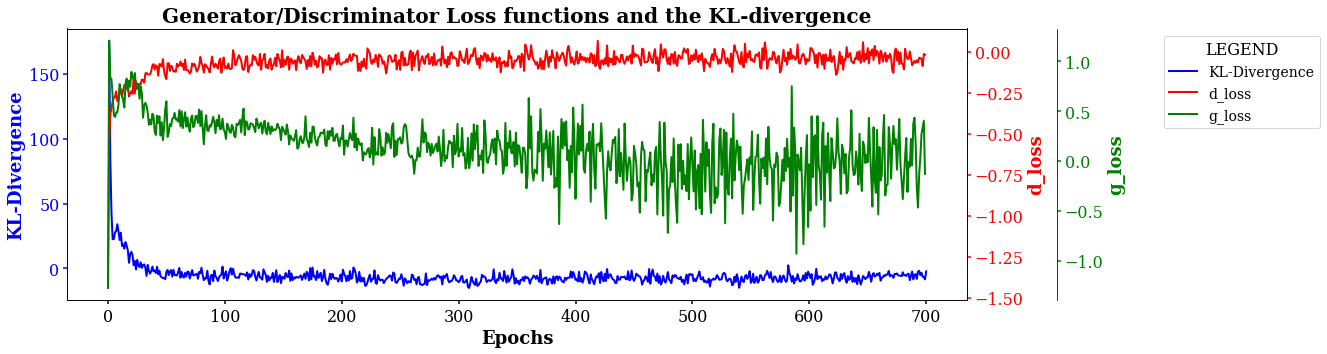

In [30]:
# Plots the loss functions of Discriminator and Generator and the KL-divergence obtained during training 
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

## Main function

def plot_metric(history= None, cbk= None, _list= None):
    if not _list:
        g_loss= history.history['g_loss']
        d_loss= history.history['d_loss']
        kl= np.array(cbk.kl_tracker)
    elif _list: 
        g_loss= _list[0]
        d_loss= _list[1]
        kl= _list[2]
        
    #function to set our spines invisible 
    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)



    # ------------------        
    ## Main Graph 
    # ------------------


    #setup figure 
    fig, host = plt.subplots(figsize=[20, 5])
    fig.subplots_adjust(right=0.75)
    par1 = host.twinx()
    par2 = host.twinx()
    # Offset the right spine of par2.  The ticks and label have already been
    # placed on the right by twinx above.
    par2.spines["right"].set_position(("axes", 1.1))
    # Having been created by twinx, par2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par2)
    # Second, show the right spine.
    par2.spines["right"].set_visible(True)
    # Ready to plot our graphs 
    epochs = range(1, len(g_loss) + 1)
    p1, = host.plot(epochs, kl, 'b', label="KL-Divergence")
    p2, = par1.plot(d_loss, 'r', label="d_loss")
    p3, = par2.plot(g_loss, 'g', label="g_loss")
    # Name labels appropriately 
    host.set_xlabel("Epochs", fontweight='bold')
    host.set_ylabel("KL-Divergence", fontweight='bold')
    par1.set_ylabel("d_loss", fontweight='bold')
    par2.set_ylabel("g_loss", fontweight='bold')
    # Keep coloring uniform across the entire figure 
    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())
    # Clean up ticks 
    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)
    # Add outside legend and give title
    lines = [p1, p2, p3]
    host.legend(lines, [l.get_label() for l in lines], title= 'LEGEND', bbox_to_anchor=(1.40, 1),)
    plt.title('Generator/Discriminator Loss functions and the KL-divergence', fontweight='bold')


    # ------------------------------
    ## Zoom-ins to get more detail 
    # ------------------------------

#     # Zoom into a part of KL-divergence graph
#     axins = zoomed_inset_axes(host, 2, loc= 5) # (graph, zoom-in factor, location on graph to display the zoom)
#     #What to zoom in on
#     axins.plot(epochs, kl, '--')
#     x1, x2, y1, y2 = len(kl) - 100, len(kl), -20, 20 # specify the limits
#     axins.set_xlim(x1, x2) # apply the x-limits
#     axins.set_ylim(y1, y2) # apply the y-limits
#     #Add connecting lines to original plot 
#     mark_inset(host, axins, loc1=3, loc2=4, fc="none", ec="0", )

#     #Zoom into a part of the graph
#     axins = zoomed_inset_axes(par1, 2, loc= 10) # (graph, zoom-in factor, location on graph to display the zoom)
#     #What to zoom in on
#     axins.plot(epochs, d_loss, 'r')
#     x1, x2, y1, y2 = len(d_loss) - 100, len(d_loss), -0.1, 0 # specify the limits
#     axins.set_xlim(x1, x2) # apply the x-limits
#     axins.set_ylim(y1, y2) # apply the y-limits
#     #Add connecting lines to original plot 
#     mark_inset(par1, axins, loc1=2, loc2=4, fc="None", ec="0", )


## Load in data if mdl was trained on GColab 
# -------------------------------------------
_dir= os.listdir('data/interim')
g_loss = []
d_loss = []
kl= []
for eachFolder in _dir:
    g_loss.append(list(np.load(f'data/interim/{eachFolder}/g_loss.npy')))
    d_loss.append(list(np.load(f'data/interim/{eachFolder}/d_loss.npy')))
    kl.append(list(np.load(f'data/interim/{eachFolder}/kl.npy')))
    
g_loss = functools.reduce(operator.iconcat, g_loss, [])
d_loss = functools.reduce(operator.iconcat, d_loss, [])
kl = kl[-1]

  
plot_metric(_list= [g_loss, d_loss, kl])

## Postprocess datasets back to original shape 

Let's first generate some samples from the real data, `Xreal`, as well as some samples from our trained Generator, `Xfake`. Note that that we sample `Xreal` from the *pre-processed* dataset and not the *raw* dataset.

In [51]:
n_samples= 20000
Xfake, _= generate_artificial_samples(g_model, noise_dim, n_samples)
Xreal, _= generate_real_samples(dataset, n_samples)

Now, let's estimate the KLdivergence between `Xreal` and `Xfake`:

In [133]:
#Latex(print('Estimated KL-divergence:', KLdivergence(Xreal, Xfake, k=5) )); 
# Get results from cloud
display(Latex("Estimated KL-divergence: 4.190287702424854"))

<IPython.core.display.Latex object>

Let's start post-processing both `Xreal` and `Xfake`. The goal is to reverse engineer the pre-processing steps we took initially in order to convert `Xreal` back to it's *raw* state. In the meantime we apply the exact same set of transformations for `Xfake` to have the generated data in the same format as the original raw data.

We first decompose the datasets in their conntinous and discrete variables:

In [52]:
# Dimensions 
dimContinuous= len(continuousColumns)
dimNominal= len(nominalColumns)

# Artificial Dataset 
Xfake_continuous= Xfake[:,0:dimContinuous] 
Xfake_nominal= Xfake[:, dimContinuous:]

# Real Dataset 
Xreal_continuous= Xreal[:, 0:dimContinuous]
Xreal_nominal= Xreal[:, dimContinuous:]

Then we start to post-process the nominal data by going from noisy marginal distributions to a clean one-hot encoded format:

In [53]:
# Divide datasets into separated columns for each nominal variable

XrealSeparated= variableSeparator(nominalColumnsValues = nominalColumnsValues, nominalDataset= Xreal_nominal)
XfakeSeparated= variableSeparator(nominalColumnsValues = nominalColumnsValues, nominalDataset= Xfake_nominal)

# Function to transform from p() to ohe 
def retransformer(nominalVariable): 
  idx = nominalVariable.argmax(axis=1)
  out = np.zeros_like(nominalVariable,dtype=float)
  out[np.arange(nominalVariable.shape[0]), idx] = 1
  return out

# Transform columns into one-hot encoding format
Xreal_transformed= []
Xfake_transformed= []
for eachVariable in XrealSeparated:
    tmp= retransformer(eachVariable)
    Xreal_transformed.append(tmp)
for eachVariable in XfakeSeparated:
    tmp= retransformer(eachVariable)
    Xfake_transformed.append(tmp)


# Concatenate back into one dataset
Xreal_nominal = np.concatenate((Xreal_transformed), axis=1)
Xfake_nominal = np.concatenate((Xfake_transformed), axis=1)

Next, we post-process the continous data from the range $[-1,1]$ back to their original domain:

### Real dataset 

In [54]:
Xreal_continuous_renormalized= ( ((Xreal_continuous + 1) / 2) * (maximum[:, None].T - minimum[:, None].T) 
                                + minimum[:, None].T)

### Artificial dataset 

In [55]:
Xfake_continuous_renormalized= ( ((Xfake_continuous + 1) / 2) * (maximum[:, None].T - minimum[:, None].T) 
                                + minimum[:, None].T)

Finally, we merge all post-processed data into final matrix/dataFrame:

In [56]:
# Real dataset
Xreal= np.concatenate( (Xreal_continuous_renormalized, Xreal_nominal), axis= 1)
# Artificial dataset 
Xfake= np.concatenate( (Xfake_continuous_renormalized, Xfake_nominal), axis= 1)

# Evaluate the *similarity* between real and artificial distributions 

Let's recompute the KL-divergence but now for the postprocessed datasets. We see that the divergence is much larger than before. Two possible reasons: 
  
1. Our implementation of the KL-divergence estimator doesn't work properly with mixed distributions (see the KL-divergence notebook for more information) 
2. Postprocessing setup contains errors.




In [128]:
#Latex(print('Estimated KL-divergence:', KLdivergence(Xreal, Xfake, k=10)));
# Get results from cloud
display(Latex("Estimated KL-divergence: 66.49804921560046"))

<IPython.core.display.Latex object>

## Visualisation of real and artificial distributions 

Let us plot the continuous marginal distributions of the real dataset (blue) and overlay them with the continuous marginals of the generated dataset (orange) . We observe quite satisfactory visual results with the artificial dataset being able to capture most marginals quite closely. Note especially, on the zoomed in plots, how the improved model is able to capture a wider range of multimodal distributions, which is in great contrast with the earlier versions we implemented. 

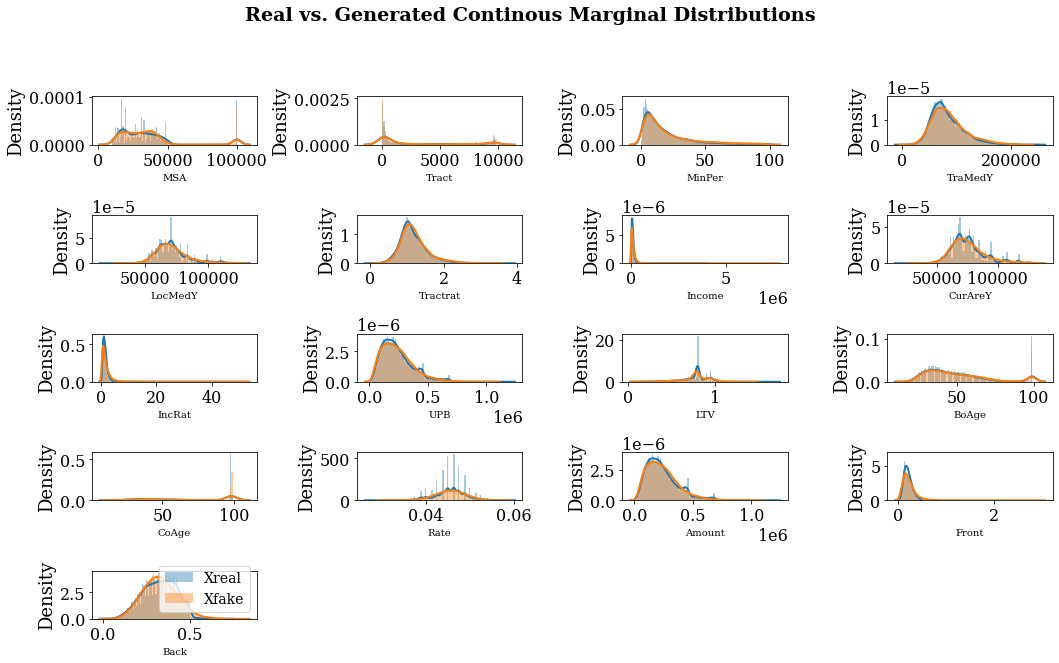

In [57]:
dim= Xreal_continuous_renormalized.shape[1]
fig= plt.figure(figsize=[15, 30])
for eachDimension in range(dim):
    plt.subplot(dim, 4, eachDimension+1)
    sns.distplot(Xreal_continuous_renormalized[:,eachDimension], bins= 100, label= 'Xreal')
    sns.distplot(Xfake_continuous_renormalized[:,eachDimension], bins= 100, label= 'Xfake')
    plt.xlabel(continuousColumns[eachDimension], fontsize = 10)
plt.legend()
plt.suptitle('Real vs. Generated Continous Marginal Distributions', fontweight= 'bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

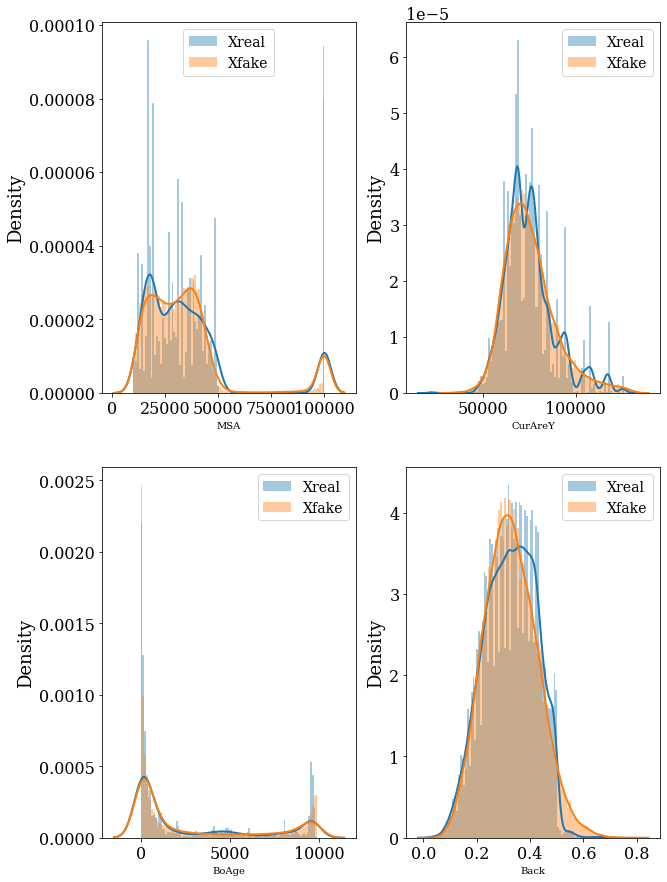

In [58]:
# Close up of some marginal distributions 

fig= plt.figure(figsize=[10,15])
plt.subplot(2,2,1)
sns.distplot(Xreal_continuous_renormalized[:,0], bins= 100, label= 'Xreal')
sns.distplot(Xfake_continuous_renormalized[:,0], bins= 100, label= 'Xfake')
plt.xlabel(continuousColumns[0], fontsize = 10)
plt.legend();

plt.subplot(2,2,2)
sns.distplot(Xreal_continuous_renormalized[:, 7], bins= 100, label= 'Xreal')
sns.distplot(Xfake_continuous_renormalized[:, 7], bins= 100, label= 'Xfake')
plt.xlabel(continuousColumns[7], fontsize = 10)
plt.legend();

plt.subplot(2,2,3)
sns.distplot(Xreal_continuous_renormalized[:,1], bins= 100, label= 'Xreal')
sns.distplot(Xfake_continuous_renormalized[:,1], bins= 100, label= 'Xfake')
plt.xlabel(continuousColumns[11], fontsize = 10)
plt.legend();

plt.subplot(2,2,4)
sns.distplot(Xreal_continuous_renormalized[:,-1], bins= 100, label= 'Xreal')
sns.distplot(Xfake_continuous_renormalized[:,-1], bins= 100, label= 'Xfake')
plt.xlabel(continuousColumns[-1], fontsize = 10)
plt.legend();

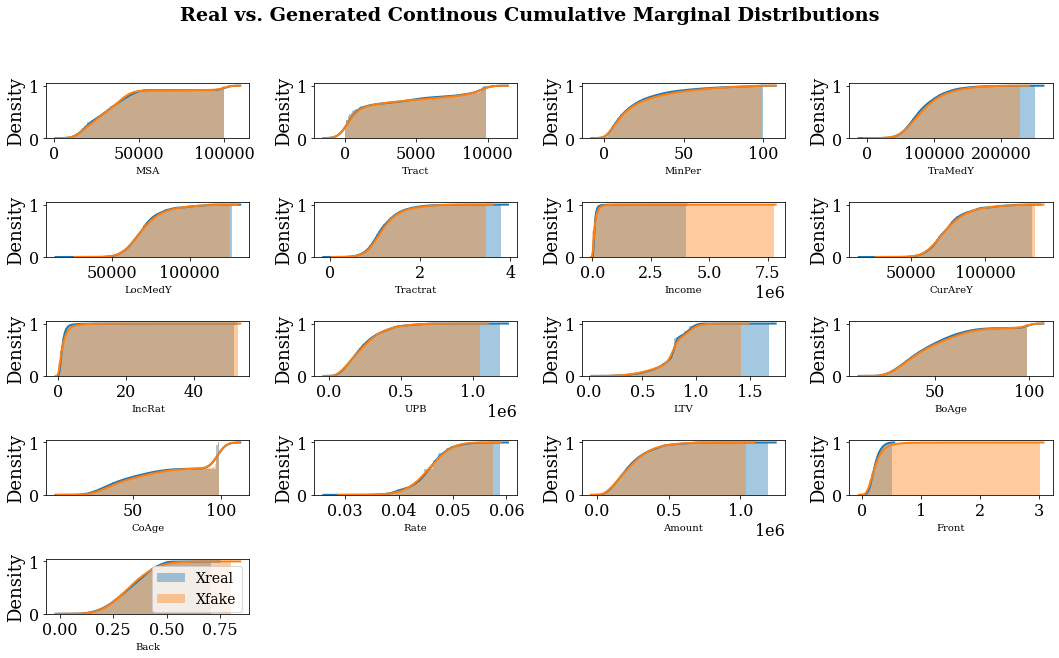

In [59]:
dim= Xreal_continuous_renormalized.shape[1]
fig= plt.figure(figsize=[15, 30])
for eachDimension in range(dim):
    plt.subplot(dim, 4, eachDimension+1)
    kwargs = {'cumulative': True}
    sns.distplot(Xreal_continuous_renormalized[:,eachDimension], bins= 100, label= 'Xreal', hist_kws=kwargs, kde_kws=kwargs)
    sns.distplot(Xfake_continuous_renormalized[:,eachDimension], bins= 100, label= 'Xfake', hist_kws=kwargs, kde_kws=kwargs)
    plt.xlabel(continuousColumns[eachDimension], fontsize = 10)
plt.legend()
plt.suptitle('Real vs. Generated Continous Cumulative Marginal Distributions', fontweight= 'bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

It is of interest to see whether we are able to capture the Dirac delta point embedded within the `Age` variable distribution. If we look at the number of $99$ values within the original dataset we see a frequency of 1721. However, the synthetic dataset contains only 420 observations with $99$ values. If we instead look at the number of observations with an age value of _around_ $99$ we see a frequency of $1536$. Thus, it seems as if `MIXED-WGAN-GP` tries to approximate the delta point through a local Gaussian like distribution with high excess kurtosis.

In [62]:
# Check number of zero values 
display(Latex(f"Xreal - number of $99$ values: ${np.sum(Xreal_continuous_renormalized[:,11] == 99)}$"))
display(Latex(f"Xfake - number of $99$ values: ${np.sum(Xfake_continuous_renormalized[:,11] == 99)}$"))
display(Latex(f"""Xfake - number of values around $99$: 
${np.sum((Xfake_continuous_renormalized[:,11] < 110)) & 
(np.sum((Xfake_continuous_renormalized[:,11] > 90)))}$"""))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Correlations between continuous variables 

Next, we evaluate the pairwise correlation matrix of the generated with that of the original dataset. After computing the (Pearson)correlation matrices for both datasets, we compute the elementwise difference. The absolute _difference_ matrix contains elements $|D_{i,j}| \in [0,2]$ with $D_{i,j}  = 0$ indicating that the Pearson correlation between variables $i$ and $j$ is the exact same whether we compute the correlation with the original or the generated dataset. On the other hand, when  $D_{i,j}  = 2$ we witness a maximum divergence between the computed correlations across the true and generated dataset. Looking at the results we see that the generated data is mostly aligned with the orignal one, except for some outliers that need to be further investigated. 

In [63]:
# Correlation structure within the real dataset 
Xreal_corr= pd.DataFrame(data= np.round(np.corrcoef(Xreal_continuous_renormalized, rowvar= False), 2), 
                         columns=continuousColumns,
                        index= continuousColumns)

# Correlation structure within the fake dataset 
Xfake_corr= pd.DataFrame(data= np.round(np.corrcoef(Xfake_continuous_renormalized, rowvar= False), 2), 
                         columns=continuousColumns,
                        index= continuousColumns)

# Difference in correlation structure between the datasets 
X_corr_diff= Xreal_corr - Xfake_corr
display(Latex('A sample of the difference correlation matrix:'))
_sample= X_corr_diff.sample(n=10, axis=1)
display(_sample.loc[_sample.columns].abs())

<IPython.core.display.Latex object>

UPB  TraMedY  BoAge  MinPer  Back  Tract  Tractrat  IncRat  LocMedY  \
UPB      0.00     0.03   0.00    0.01  0.05   0.03      0.00    0.04     0.03   
TraMedY  0.03     0.00   0.07    0.02  0.07   0.02      0.01    0.05     0.03   
BoAge    0.00     0.07   0.00    0.09  0.03   0.05      0.11    0.13     0.07   
MinPer   0.01     0.02   0.09    0.00  0.08   0.02      0.01    0.01     0.07   
Back     0.05     0.07   0.03    0.08  0.00   0.08      0.03    0.08     0.08   
Tract    0.03     0.02   0.05    0.02  0.08   0.00      0.01    0.08     0.01   
Tractrat 0.00     0.01   0.11    0.01  0.03   0.01      0.00    0.07     0.01   
IncRat   0.04     0.05   0.13    0.01  0.08   0.08      0.07    0.00     0.04   
LocMedY  0.03     0.03   0.07    0.07  0.08   0.01      0.01    0.04     0.00   
CoAge    0.06     0.07   0.07    0.12  0.18   0.00      0.03    0.10     0.21   

          CoAge  
UPB        0.06  
TraMedY    0.07  
BoAge      0.07  
MinPer     0.12  
Back       0.18  
Tract      0.00  
Tractrat   0.03  
IncRat     0.10  
LocMedY    0.21  
CoAge      0.00

## Plot nominal marginal distributions

Next, we take a look at the nominal marginal distributions of the real and generated datasets. We see that the generated data is closely aligned with the original dataset. Note especially how `MIXED-WGAN-GP` is able to capture highly imbalanced distributions. When the number of potential categories increases (see `Country Codes`) we see that the model has trouble replicating the data. 

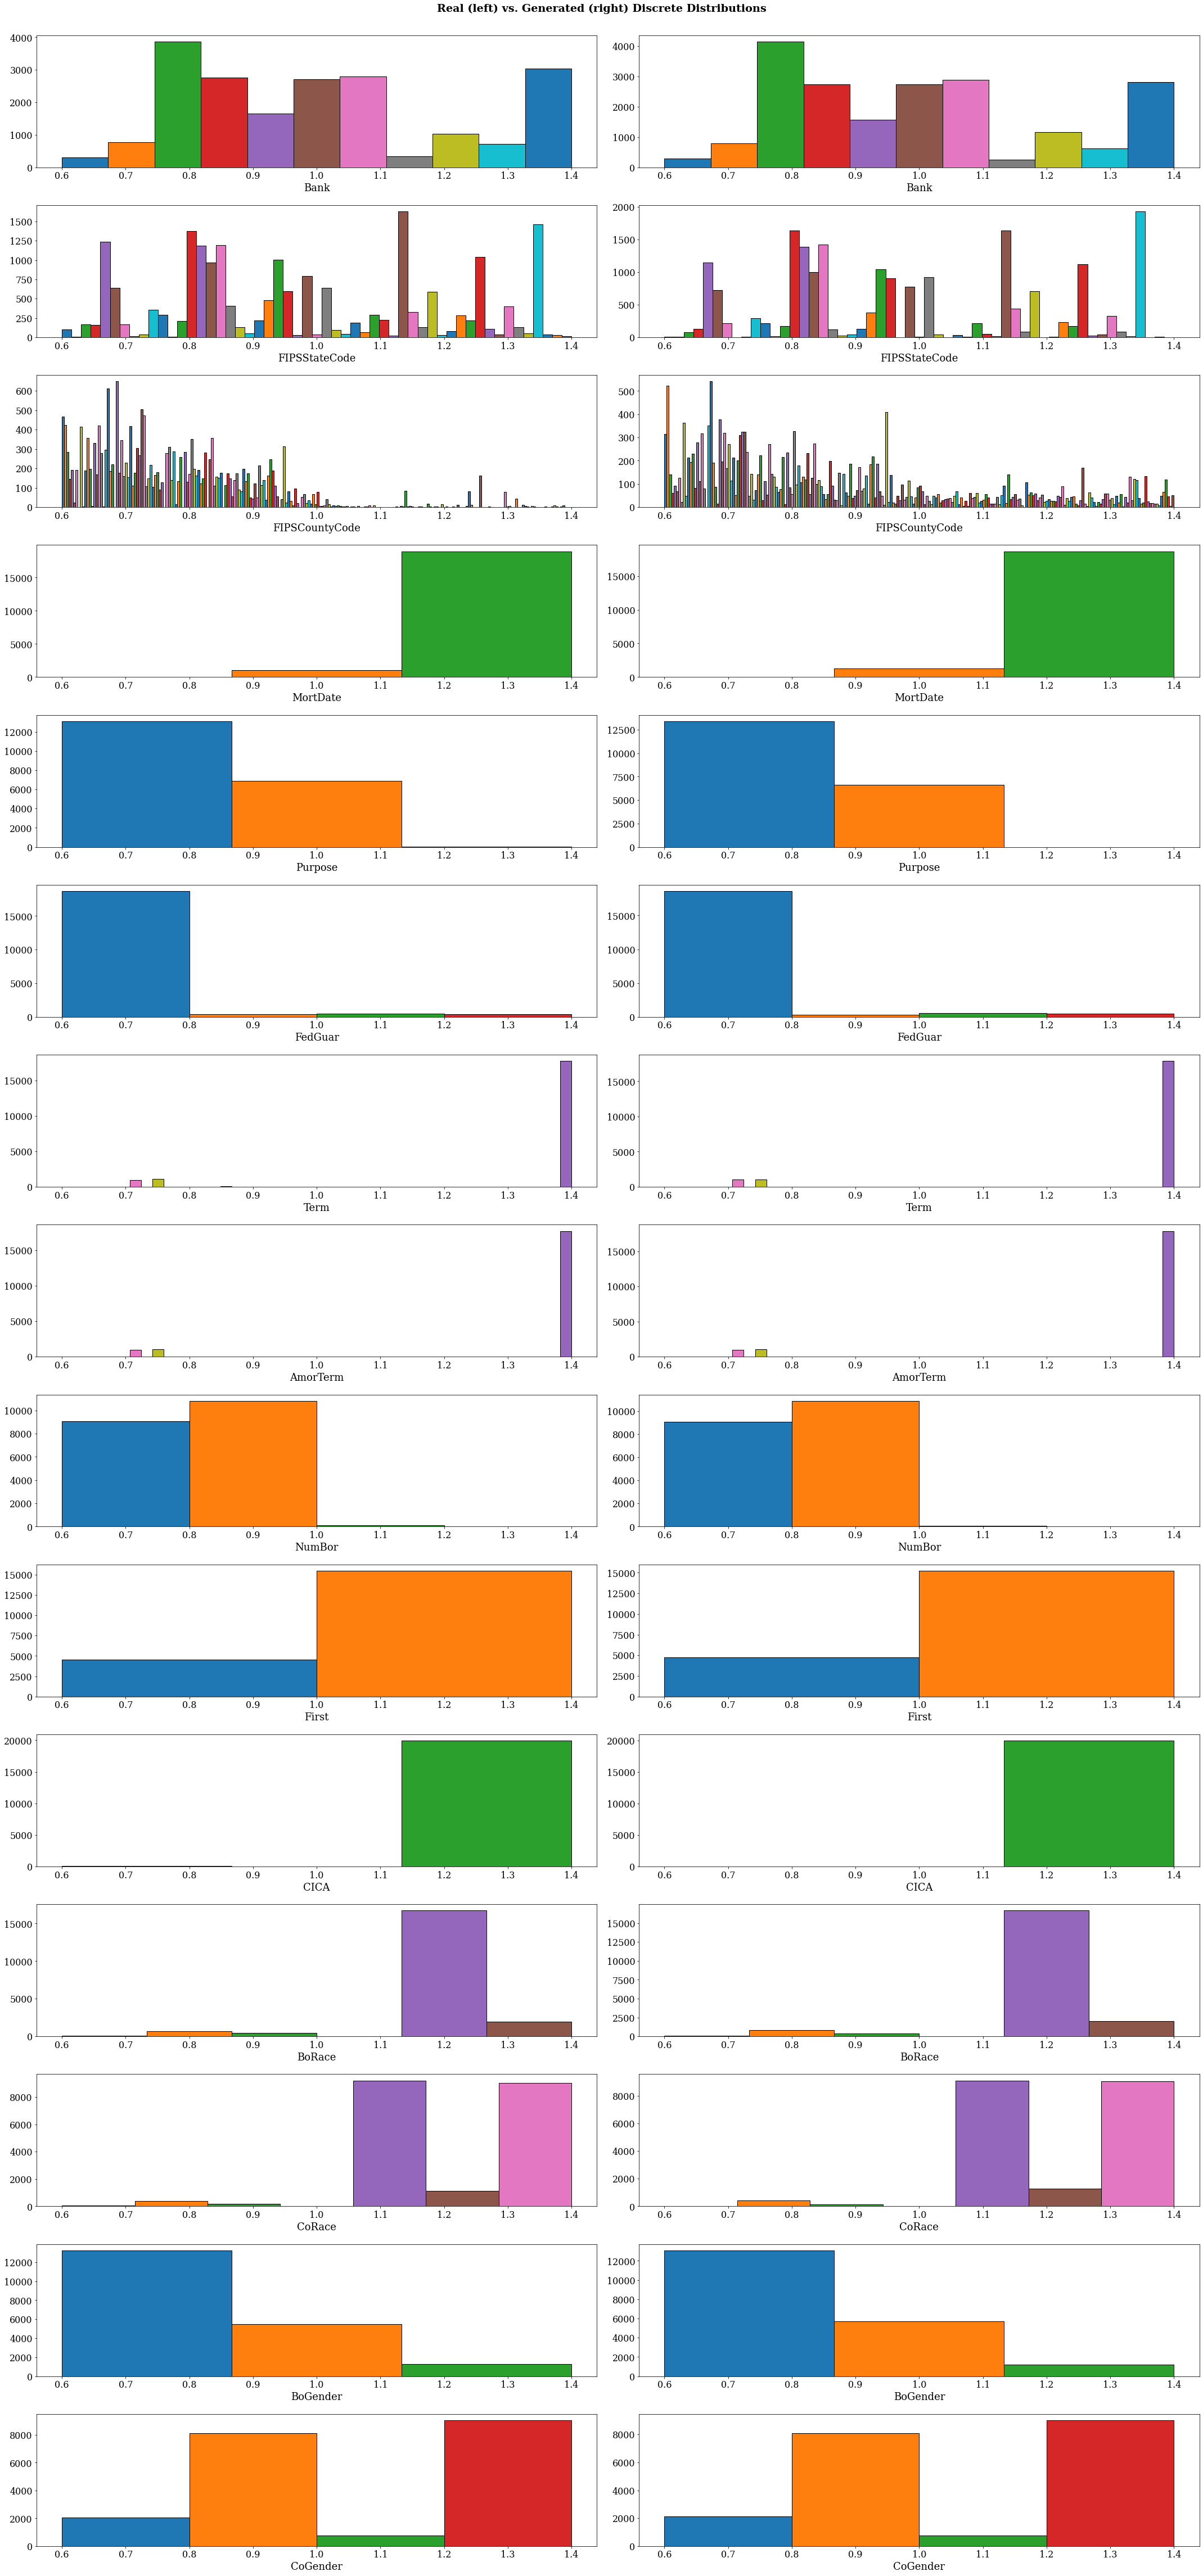

In [110]:
#fig= plt.figure(figsize=[10, 45])
dim= len(nominalColumnsValues)
idx_Xreal=np.arange(1,dim*2,2)
idx_Xfake=np.arange(2,dim*2+2,2)
plt.figure(figsize=(30, 150)) 
for eachVariable in range(dim-20):
    

    plt.subplot(dim, 2, idx_Xreal[eachVariable], )
    plt.hist(retransformer(XrealSeparated[eachVariable]), bins=[.5,.5,1.5], ec= 'k')
    plt.xlabel(nominalColumns[eachVariable])
    
    plt.subplot(dim, 2, idx_Xfake[eachVariable])
    plt.hist(retransformer(XfakeSeparated[eachVariable]), bins=[.5,.5,1.5], ec= 'k')
    plt.xlabel(nominalColumns[eachVariable])
    
    
plt.suptitle('Real (left) vs. Generated (right) Discrete Distributions', fontweight= 'bold');
plt.tight_layout(rect=[0, 0, 1, 0.98])


To analyse how well the model is able to capture the relationship between nominal distributions we rely on the pairwise mutual information matrix. The _mutual information_ between two random discrete variables X and Y measures the amount of information that is being shared by the two variables. In case the two variables are independent from each other, they won't share any mutual information with each other and $I(X; Y) = 0$. On the other hand, if knowing something about X gives us additional information about the (expected) behaviour of Y then we do have mutual information across both variables and  $I(X; Y) > 0$. Similar to the correlation matrix of continuous variables, we compute the _difference_ matrix between the pairwise mutual information matrix of the true and generated datasets.

 The absolute _difference_ matrix contains elements $|D_{i,j}| \in [0, \infty]$ with $D_{i,j}  = 0$ indicating that the mutual information between variables $i$ and $j$ is the exact same whether we compute the measure with the original or the generated dataset. On the other hand, when  $D_{i,j}  > 0$ we witness a divergence between the computed mutual information measure across the true and generated dataset. Looking at the results ...

In [114]:
## Convert nominal synthetic data to condensed df 

#get all of the nominal variables (in one-hot encoded format)
nominalVariablesList = variableSeparator(nominalColumnsValues = nominalColumnsValues, nominalDataset= Xreal_nominal)
#initialize dataframe before loop
df_Xfake_nominal= pd.DataFrame()
#Tranform from one-hot encoding to original shape for each nominal variable 
for eachColumn in range(len(nominalVariablesList )):
    #create dataFrame object 
    tmp= pd.DataFrame(nominalVariablesList[eachColumn])
    #equate column names to unique values of the variable 
    uniqueValues= datasetNominal.iloc[:,eachColumn].unique()
    uniqueValues.sort() #sort values (just like ohe of sklearn does)
    tmp.columns= uniqueValues 
    #condense one-hot encoding back to original shape 
    tmp2= tmp.idxmax(axis='columns')
    #concatenate into one dataFrame containing all of the nominal columns 
    df_Xfake_nominal= pd.concat([df_Xfake_nominal, tmp2], axis= 1)
#name the columns appropriately 
df_Xfake_nominal.columns= nominalColumns
# Convert categories to int 
df_Xfake_nominal = df_Xfake_nominal.apply(lambda col:pd.Categorical(col).codes)


## Convert nominal real data to condensed df 

#get all of the nominal variables (in one-hot encoded format)
nominalVariablesList = variableSeparator(nominalColumnsValues = nominalColumnsValues, nominalDataset= Xfake_nominal)
#initialize dataframe before loop
df_Xreal_nominal= pd.DataFrame()
#Tranform from one-hot encoding to original shape for each nominal variable 
for eachColumn in range(len(nominalVariablesList )):
    #create dataFrame object 
    tmp= pd.DataFrame(nominalVariablesList[eachColumn])
    #equate column names to unique values of the variable 
    uniqueValues= datasetNominal.iloc[:,eachColumn].unique()
    uniqueValues.sort() #sort values (just like ohe of sklearn does)
    tmp.columns= uniqueValues 
    #condense one-hot encoding back to original shape 
    tmp2= tmp.idxmax(axis='columns')
    #concatenate into one dataFrame containing all of the nominal columns 
    df_Xreal_nominal= pd.concat([df_Xreal_nominal, tmp2], axis= 1)
#name the columns appropriately 
df_Xreal_nominal.columns= nominalColumns
# Convert categories to int 
df_Xreal_nominal = df_Xreal_nominal.apply(lambda col:pd.Categorical(col).codes)


In [115]:
## Real dataset 

#Initialize Pairwise Mutual Information Matrix  
PMI_real= np.empty([df_Xreal_nominal.shape[1], df_Xreal_nominal.shape[1] ])
#Compute PMI for every column of the real dataset
for eachColumn in range(0, df_Xreal_nominal.shape[1]):
    PMI_real[:, eachColumn]= mutual_info_classif(df_Xreal_nominal.values, df_Xreal_nominal.iloc[:, eachColumn], discrete_features= True)
#convert to DataFrame
PMI_real= pd.DataFrame(data= PMI_real, columns=nominalColumns, index= nominalColumns)

## Fake dataset 

#Initialize Pairwise Mutual Information Matrix  
PMI_fake= np.empty([df_Xfake_nominal.shape[1], df_Xfake_nominal.shape[1] ])
#Compute PMI for every column of the real dataset
for eachColumn in range(0, df_Xfake_nominal.shape[1]):
    PMI_fake[:, eachColumn]= mutual_info_classif(df_Xfake_nominal.values, df_Xfake_nominal.iloc[:, eachColumn], discrete_features= True)
#convert to DataFrame
PMI_fake= pd.DataFrame(data= PMI_fake, columns=nominalColumns, index= nominalColumns)

## Difference between PMI of Real and Fake dataset 
PMI_diff= PMI_real - PMI_fake
display(Latex('A sample of the difference Pairwise Mutual Information matrix:'))
_sample= PMI_diff.sample(n=10, axis=1)
display(_sample.loc[_sample.columns].abs())

<IPython.core.display.Latex object>

PropType  BoRace  Race4  NumUnits  MortDate  Corace2  \
PropType           0.03    0.00   0.00      0.03      0.00     0.00   
BoRace             0.00    0.00   0.00      0.00      0.00     0.00   
Race4              0.00    0.00   0.00      0.00      0.00     0.00   
NumUnits           0.03    0.00   0.00      0.02      0.00     0.00   
MortDate           0.00    0.00   0.00      0.00      0.04     0.00   
Corace2            0.00    0.00   0.00      0.00      0.00     0.00   
SpcHsgGoals        0.00    0.00   0.00      0.00      0.00     0.00   
Bank               0.03    0.01   0.00      0.00      0.00     0.00   
FIPSStateCode      0.05    0.03   0.00      0.00      0.00     0.02   
FedGuar            0.00    0.00   0.00      0.00      0.00     0.00   

               SpcHsgGoals  Bank  FIPSStateCode  FedGuar  
PropType              0.00  0.03           0.05     0.00  
BoRace                0.00  0.01           0.03     0.00  
Race4                 0.00  0.00           0.00     0.00  
NumUnits              0.00  0.00           0.00     0.00  
MortDate              0.00  0.00           0.00     0.00  
Corace2               0.00  0.00           0.02     0.00  
SpcHsgGoals           0.01  0.01           0.01     0.00  
Bank                  0.01  0.02           0.49     0.02  
FIPSStateCode         0.01  0.49           0.24     0.02  
FedGuar               0.00  0.02           0.02     0.02

Lastly, we can try to get a summary measure of the overall similarity between the dependence strutucture found in the true data and the generated data. To do so we first compute the pairwise mutual information matrix across all variables (both continous and discrete variables)  for both the true and generated data, $I(\pmb{X}_{true)} \text{ and } I(\pmb{X}_{generated})$. Note how $I(X)$ also captures non-linear dependencies across variables (in contrast with the Pearson correlation matrix). Next we compute the _Frobenius norm_ of the resulting matrices, 

$|I(.)|_{F}:={\sqrt {\sum _{i=1}^{m}\sum _{j=1}^{n}|I_{ij}|^{2}}}$

The _Frobenius_ norm can be seen as the extension of the _Euclidian_ distance from the vector space to the matrix space. Next, we take the absolute difference of the _Frobenius_ norm of the true and generated data, $D = I(\pmb{X}_{true}) - I(\pmb{X}_{generated})$.  the closer $|D|$ is to $0$, the more aligned the dependence structures found in the true and generated data are. 

In [116]:
## Pairwise Mutual Information of all variables
# ---------------------------------------------

from sklearn.feature_selection import mutual_info_regression

## Real dataset 

#Initialize Pairwise Mutual Information Matrix  
PMI_real= np.empty([Xreal_continuous_renormalized.shape[1] + df_Xreal_nominal.shape[1], 
                    Xreal_continuous_renormalized.shape[1] + df_Xreal_nominal.shape[1]])
idx= 0
#Compute PMI for every column of the real dataset
for eachColumn in range(0, Xreal_continuous_renormalized.shape[1] + df_Xreal_nominal.shape[1]):
    if eachColumn < Xreal_continuous_renormalized.shape[1]:
        PMI_real[:, eachColumn]= mutual_info_regression(np.concatenate( (Xreal_continuous_renormalized, df_Xreal_nominal), axis= 1), 
                                                        Xreal_continuous_renormalized[:, eachColumn])
    else: 
        PMI_real[:, eachColumn]= mutual_info_classif(np.concatenate( (Xreal_continuous_renormalized, df_Xreal_nominal), axis= 1), 
                                                     df_Xreal_nominal.iloc[:, idx])
        idx+= 1

#convert to DataFrame
PMI_real= pd.DataFrame(data= PMI_real, columns= continuousColumns + nominalColumns, index= continuousColumns + nominalColumns)


## Fake dataset 

#Initialize Pairwise Mutual Information Matrix  
PMI_fake= np.empty([Xfake_continuous_renormalized.shape[1] + df_Xfake_nominal.shape[1], 
                    Xfake_continuous_renormalized.shape[1] + df_Xfake_nominal.shape[1]])
idx= 0
#Compute PMI for every column of the real dataset
for eachColumn in range(0, Xfake_continuous_renormalized.shape[1] + df_Xfake_nominal.shape[1]):
    if eachColumn < Xfake_continuous_renormalized.shape[1]:
        PMI_fake[:, eachColumn]= mutual_info_regression(np.concatenate( (Xfake_continuous_renormalized, df_Xfake_nominal), axis= 1), 
                                                    Xfake_continuous_renormalized[:, eachColumn])
    else: 
        PMI_fake[:, eachColumn]= mutual_info_classif(np.concatenate( (Xfake_continuous_renormalized, df_Xfake_nominal), axis= 1), 
                                                 df_Xfake_nominal.iloc[:, idx])
        idx+= 1

#convert to DataFrame
PMI_fake= pd.DataFrame(data= PMI_fake, columns= continuousColumns + nominalColumns, index= continuousColumns + nominalColumns)

## Difference between PMI of Real and Fake dataset 
PMI_diff= PMI_real - PMI_fake
display(Latex('A sample of the difference Pairwise Mutual Information matrix (including continuous variables):'))
_sample= PMI_diff.sample(n=10, axis=1)
display(_sample.loc[_sample.columns].abs())

<IPython.core.display.Latex object>

PMI  CoGender  MSA  FIPSStateCode  CoRace  Race4  \
PMI           0.02      0.00 0.00           0.00    0.00   0.00   
CoGender      0.00      0.00 0.01           0.03    0.02   0.00   
MSA           0.00      0.00 3.40           0.00    0.00   0.00   
FIPSStateCode 0.01      0.02 0.00           0.24    0.00   0.00   
CoRace        0.00      0.02 0.00           0.00    0.00   0.00   
Race4         0.00      0.00 0.00           0.00    0.00   0.00   
BoCreditScore 0.00      0.00 0.01           0.01    0.01   0.00   
CoEth         0.00      0.02 0.01           0.02    0.01   0.00   
Corace2       0.01      0.02 0.00           0.02    0.02   0.00   
Race5         0.00      0.00 0.00           0.01    0.00   0.00   

               BoCreditScore  CoEth  Corace2  Race5  
PMI                     0.00   0.00     0.00   0.00  
CoGender                0.00   0.02     0.02   0.00  
MSA                     0.01   0.00     0.00   0.00  
FIPSStateCode           0.00   0.01     0.02   0.00  
CoRace                  0.00   0.01     0.02   0.00  
Race4                   0.00   0.00     0.00   0.00  
BoCreditScore           0.04   0.00     0.01   0.00  
CoEth                   0.01   0.02     0.02   0.00  
Corace2                 0.00   0.01     0.00   0.00  
Race5                   0.00   0.00     0.00   0.00

In [119]:
# Frobenius norm of real dataset PMI matrix
Xreal_fro= np.linalg.norm(PMI_real, ord= 'fro')
# Frobenius norm of synthetic dataset PMI matrix 
Xfake_fro= np.linalg.norm(PMI_fake, ord= 'fro')
# Difference in norms
X_fro_diff= np.abs(Xreal_fro - Xfake_fro)
display(Latex(f"""The absolute difference between the Frobenius norm
of the Real and Synthetic dataset PMI matrices is equal to ${np.round(X_fro_diff,2)}$."""))

<IPython.core.display.Latex object>

## We can train the model further if we believe convergence isn't reached yet:

Go back to [Step 5](#Evaluating-the-performance-of-our-trained-model) to re-evaluate the new model:

In [47]:
#wgan.fit(dataset, batch_size= batch_size, epochs= epochs, callbacks= [cbk])

Epoch 1/10
129/129 [==============================] - 52s 405ms/step - d_loss: -0.2453 - g_loss: 0.7462
Epoch 2/10
129/129 [==============================] - 53s 414ms/step - d_loss: -0.2447 - g_loss: 0.7029
Epoch 3/10
129/129 [==============================] - 53s 410ms/step - d_loss: -0.2383 - g_loss: 0.7551
Epoch 4/10
129/129 [==============================] - 56s 435ms/step - d_loss: -0.2397 - g_loss: 0.8087
Epoch 5/10
129/129 [==============================] - 53s 411ms/step - d_loss: -0.2354 - g_loss: 0.8221
Epoch 6/10
129/129 [==============================] - 56s 432ms/step - d_loss: -0.2383 - g_loss: 0.8330
Epoch 7/10
129/129 [==============================] - 53s 410ms/step - d_loss: -0.2399 - g_loss: 0.8447
Epoch 8/10
129/129 [==============================] - 53s 408ms/step - d_loss: -0.2289 - g_loss: 0.8164
Epoch 9/10
129/129 [==============================] - 55s 427ms/step - d_loss: -0.2328 - g_loss: 0.8085
Epoch 10/10
129/129 [==============================] - 53s 413ms




# Save the calibrated Generator and the synthetic dataset   

If model performance is satisfactory we can go ahead and save our trained Generator together with the synthetic dataset. 

##  Create a Pandas DataFrame of synthetic generated data

Now that we have evaluated the performance of the model and similarity of the generated data with the original dataset, we can go ahead and create a finalized dataframe. The continuous data part is already fully post-processed to the same form as the raw dataset. For the nominal (discrete) part we still need to decode the one-hot encondings into the original variables (including the original set of possible categories of every variable and their associated data types (!). Afterwards, we simply concatenate the two parts and make sure that metaschema is aligned with the original dataset. Below you see an example set of the finalized dataframe. This dataset can then either be ingested into a database or saved locally in your desired format (csv, xlsx, pickle, etc.) to be shared intrainstitutional. In case of transferring data across entities, one can simply transfer the calibrated _Generator_ which can then generate the data at the target entity. 

In [121]:
## Convert continuous synthetic data to df 

df_Xfake_continuous= pd.DataFrame(data= Xfake_continuous_renormalized, columns= continuousColumns)

## Convert nominal synthetic data to df 

#get all of the nominal variables (in one-hot encoded format)
nominalVariablesList = variableSeparator(nominalColumnsValues = nominalColumnsValues, nominalDataset= Xreal_nominal)
#initialize dataframe before loop
df_Xfake_nominal= pd.DataFrame()
#Tranform from one-hot encoding to original shape for each nominal variable 
for eachColumn in range(len(nominalVariablesList )):
    #create dataFrame object 
    tmp= pd.DataFrame(nominalVariablesList[eachColumn])
    #equate column names to unique values of the variable 
    uniqueValues= datasetNominal.iloc[:,eachColumn].unique()
    uniqueValues.sort() #sort values (just like ohe of sklearn does)
    tmp.columns= uniqueValues 
    #condense one-hot encoding back to original shape 
    tmp2= tmp.idxmax(axis='columns')
    #concatenate into one dataFrame containing all of the nominal columns 
    df_Xfake_nominal= pd.concat([df_Xfake_nominal, tmp2], axis= 1)
#name the columns appropriately 
df_Xfake_nominal.columns= nominalColumns

## Merge the continuous and nominal synthetic data to one df 
df_Xfake= pd.concat([df_Xfake_continuous, df_Xfake_nominal], axis= 1)
#match the same layout of the original dataset
df_Xfake= df_Xfake[ [i for i in list(FHL_bank.columns) + redudantColumns if i not in list(FHL_bank.columns) or i not in redudantColumns] ]

In [122]:
display(df_Xfake.head()[df_Xfake.columns[:11]])

Bank  FIPSStateCode  FIPSCountyCode       MSA    Tract  MinPer  \
0  Cincinnati             39              61 15,782.47   168.61    0.93   
1  Pittsburgh             42             119 20,414.34    49.24   48.79   
2      Topeka             20              65 99,998.99 7,899.64   24.09   
3  Cincinnati             13             121 16,844.86 8,401.20   53.23   
4     Chicago             17             119 25,068.78   695.42   15.85   

     TraMedY   LocMedY  Tractrat     Income   CurAreY  
0  66,082.29 57,131.52      1.14  18,225.54 61,375.05  
1  75,290.76 85,041.13      0.77  80,696.87 90,718.98  
2  57,703.41 58,268.30      0.92  15,749.39 56,595.93  
3  78,219.19 77,038.09      0.97 257,826.18 77,046.98  
4 109,221.54 68,532.93      1.60  44,106.94 73,211.93

## Save Generator and synthetic dataset either locally or on the cloud:

In [123]:
LCL= True

In [124]:
if LCL:
    df_Xfake.to_csv(f'data/processed/fhl_generated_{datetime.now().strftime("%d-%m-%Y_%H%M%S")}.csv')
else:
    df_Xfake.to_csv(f'/content/gdrive/My Drive/Stress Testing with GANs/data/processed/fhl_generated_{datetime.now().strftime("%d-%m-%Y_%H%M%S")}.csv')

# Experimental

We add one more robustness check to validate the performance of generative models. The idea is to utilize a machine learning classifier to try and learn the difference between the true data and the synthetic data generated by a calibrated _Generator_. In case the ML model fails to find a hyperplane that separates the real and synthetic data, and allocates a 50% probability of a sample coming from either the real or synthetic dataset, we can conclude that the synthetic data is highly similar to the original dataset. We choose the XGBoost classifier for the exercise, as it has the best performance on [Kaggle](https://www.kaggle.com/) for binary classification problems. 

## Import libs to setup XGBoost model

In [125]:
## XGBoost libs
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, 
 classification_report, recall_score, precision_score)

## Create one randomly mixed dataset containing both real world and synthetic samples

The mixed dataset contains random samples drawn from both the real world dataset as well as from data directly generated by our calibrated _Generator_. We add a boolean target variable to the mixed dataset, with $1$ representing the fact that the observation is drawn from the _Generator_ and $0$ indicating that the observation is a real world sample. We further make the distinction between a mixed dataset that is not yet post-processed, and one that is fully post-processed and is identicial (in terms of meta schema) to the original dataset. We also make a further distinction between continous and discrete data, such that we can further pinpoint where the _Generator_ potentially fails to produce high quality data.

In [129]:
## Create one dataset consisting of real and fake data 
# -----------------------------------------------------


## Entire dataset (not post-processed)
# -------------------------------------------


#Generate mixed dataset
n_samples= 10 #len(FHL_bank)
Xfake, _= generate_artificial_samples(g_model, noise_dim, n_samples)
Xreal, _= generate_real_samples(dataset, n_samples)
#synthetic data gets labeled with 1
Xfake_new= np.ones((n_samples,Xfake.shape[1]+1))
Xfake_new[:,:-1]= Xfake  
#real data gets labeled with 0
Xreal_new= np.zeros((n_samples,Xfake.shape[1]+1))
Xreal_new[:,:-1]= Xreal
#combine synthetic and real data
df_XGBOOST_Entire= np.concatenate( (Xfake_new, Xreal_new), axis=0)



## Entire dataset (post-processed)
# ---------------------------------------------

#synthetic data gets labeled with 1
Xfake_new= np.ones((n_samples, df_Xfake.shape[1]+1))
df_Xfake = df_Xfake.apply(lambda col:pd.Categorical(col).codes) # Convert categories of dataset to type int 
Xfake_new[:,:-1]= df_Xfake.iloc[:n_samples, :]  
#real data gets labeled with 0
Xreal_new= np.zeros((n_samples,df_Xfake.shape[1]+1))
FHL_bank = FHL_bank.apply(lambda col:pd.Categorical(col).codes) # Convert categories of dataset to type int 
Xreal_new[:,:-1]= FHL_bank[ continuousColumns + nominalColumns].sample(n = n_samples)
#combine synthetic and real data
df_XGBOOST_Entire_processed= np.concatenate( (Xfake_new, Xreal_new), axis=0)


## Nominal dataset (not post-processed)
# -------------------------------------------

#generate data
Xfake, _= generate_artificial_samples(g_model, noise_dim, n_samples)
Xreal, _= generate_real_samples(dataset, n_samples)
Xfake_nominal= Xfake[:, dimContinuous:]
Xreal_nominal= Xreal[:, dimContinuous:]
#synthetic data gets labeled with 1
Xfake_new= np.ones((n_samples,Xfake_nominal.shape[1]+1))
Xfake_new[:,:-1]= Xfake_nominal  
#real data gets labeled with 0
Xreal_new= np.zeros((n_samples,Xreal_nominal.shape[1]+1))
Xreal_new[:,:-1]= Xreal_nominal
#combine synthetic and real data
df_XGBOOST_Nominal= np.concatenate( (Xfake_new, Xreal_new), axis=0)


## Nominal dataset (post-processed)
# ------------------------------------------

#synthetic data gets labeled with 1
Xfake_new= np.ones((n_samples, df_Xfake_nominal.shape[1]+1))
df_Xfake_nominal = df_Xfake_nominal.apply(lambda col:pd.Categorical(col).codes) # Convert categories of dataset to type int 
Xfake_new[:,:-1]= df_Xfake_nominal.iloc[:n_samples, :]  
#real data gets labeled with 0
Xreal_new= np.zeros((n_samples,df_Xfake_nominal.shape[1]+1))
datasetNominal = datasetNominal.apply(lambda col:pd.Categorical(col).codes) # Convert categories of dataset to type int 
Xreal_new[:,:-1]= datasetNominal.sample(n= n_samples)
#combine synthetic and real data
df_XGBOOST_Nominal_processed= np.concatenate( (Xfake_new, Xreal_new), axis=0)


## Continuous dataset (not post-processed)
# -----------------------------------------------

#generate data
Xfake, _= generate_artificial_samples(g_model, noise_dim, n_samples)
Xreal, _= generate_real_samples(dataset, n_samples)
Xfake_continuous= Xfake[:,0:dimContinuous] 
Xreal_continuous= Xreal[:, 0:dimContinuous]
#synthetic data gets labeled with 1
Xfake_new= np.ones((n_samples,Xfake_continuous.shape[1]+1))
Xfake_new[:,:-1]= Xfake_continuous  
#real data gets labeled with 0
Xreal_new= np.zeros((n_samples,Xreal_continuous.shape[1]+1))
Xreal_new[:,:-1]= Xreal_continuous
#combine synthetic and real data
df_XGBOOST_Continuous= np.concatenate( (Xfake_new, Xreal_new), axis=0)


## Continuous dataset (post-processed)
# ------------------------------------------------------------

#synthetic data gets labeled with 1
Xfake_new= np.ones((n_samples, df_Xfake_continuous.shape[1]+1))
Xfake_new[:,:-1]= df_Xfake_continuous.iloc[:n_samples, :]  
#real data gets labeled with 0
Xreal_new= np.zeros((n_samples,df_Xfake_continuous.shape[1]+1))
Xreal_new[:,:-1]= datasetContinuous.sample(n= n_samples)
#combine synthetic and real data
df_XGBOOST_Continuous_processed= np.concatenate( (Xfake_new, Xreal_new), axis=0)

In [135]:
## Train and evaluate XGBOOST using different datasets 


# Initialize loop
datasets_XGBOOST= [df_XGBOOST_Entire, df_XGBOOST_Entire_processed,
                   df_XGBOOST_Nominal, df_XGBOOST_Nominal_processed,
                   df_XGBOOST_Continuous, df_XGBOOST_Continuous_processed]

names= ['Entire dataset',  'Entire dataset + processed',
        'Nominal dataset',  'Nominal dataset + processed',
        'Continuous dataset',  'Continuous dataset + processed']

j= 0

# Main loop
for everyDataset in datasets_XGBOOST:

  ## Create train and training set 

  #get labels
  X= everyDataset[:,0:-1]
  y= everyDataset[:,-1]

  #setup train en test sets 
  seed = 1
  test_size = 0.33
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

  ## Train model and get accuracy on test set

  model = XGBClassifier(use_label_encoder=False, eval_metric= 'error')
  model.fit(X_train, y_train);

  y_pred = model.predict(X_test)
  predictions = [round(value) for value in y_pred]

  accuracy = accuracy_score(y_test, predictions)
  display(Markdown("The accuracy of the trained XGBoost model on the `%s` is equal to: $%.2f\%%$" % (names[j], accuracy * 100.0)))
#   if j % 2 != 0:
#     print('----------------------')
  j+= 1

The accuracy of the trained XGBoost model on the `Entire dataset` is equal to: $57.14\%$

The accuracy of the trained XGBoost model on the `Entire dataset + processed` is equal to: $100.00\%$

The accuracy of the trained XGBoost model on the `Nominal dataset` is equal to: $57.14\%$

The accuracy of the trained XGBoost model on the `Nominal dataset + processed` is equal to: $100.00\%$

The accuracy of the trained XGBoost model on the `Continuous dataset` is equal to: $71.43\%$

The accuracy of the trained XGBoost model on the `Continuous dataset + processed` is equal to: $71.43\%$

The results of the robustness check are quite interesting. When looking at the accuracy of the classifier for the unprocessed dataset, we see a performance close to 50%. This indicated that indeed the _Generator_ is able to create synthetic data that is statistically almost indistinguishable from the real data. However, as soon as the synthetic data is post-processed, the classifier is able to perfectly distinguish the data from the original dataset. 

We can try to pinpoint the reason of this behaviour by splitting the data into two subsets: continuous and discrete variables. Looking at the subset of continuous variables, we see consistent performance across unprocessed and post-processed data with the classifier achieving an accuracy of about $70\%$. Looking at the subset of discrete data however, we see inconsistencies across unprocessed and post-processed data. Although the performance of the classifier is only 57% with unprocessed data, it achieved a perfect score when it comes to post-processed discrete data. This indicates that the processing of discrete data needs to be further investigated. Although the model trained has probably not yet achieved convergence (indicating the possibility of better performance with continuous data), this won't matter too much with the performance of post-processed discrete data.  